### A series of attempts to answer Google-able questions with the power of python. 
II. Explore correlations to crime rate    

Resources used include Uniform Crime Reporting Statistics - UCR Data Online, which produces CSV files based on variety of user-specified parameters:
http://www.ucrdatatool.gov/

Note: UCR provides this caution against drawing broad conclusions based on limited selection
of data to investigate here http://www.ucrdatatool.gov/ranking.cfm

Also note:  Rates are the number of reported offenses per 100,000 population by UCR

##  2.I First look at crime rates, based on NYT article http://www.nytimes.com/interactive/2016/09/08/us/us-murder-rates.html?hp&action=click&pgtype=Homepage&clickSource=story-heading&module=photo-spot-region&region=top-news&WT.nav=top-news&_r=0

In [1]:
#!/usr/bin/env python
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
%matplotlib inline

In [2]:
# Columns in CSV crime files from UCR are the following: 
cols = ['Year','Population','Violent crime total','Murder and nonnegligent Manslaughter',\
    'Forcible rape','Robbery','Aggravated assault','Property crime total','Burglary','Larceny-theft','Motor vehicle theft',\
    'Violent Crime rate','Murder and nonnegligent manslaughter rate','Forcible rape rate','Robbery rate',\
    'Aggravated assault rate','Property crime rate','Burglary rate','Larceny-theft rate','Motor vehicle theft rate']

################ BY CITY
data_Chi = pd.read_csv("Cities/ChicagoPDCrimeStats.csv")
df_Chi = pd.DataFrame(data_Chi,columns=cols)

data_NYPD = pd.read_csv("Cities/NYPDCrimeStats.csv",error_bad_lines=False)
df_NYPD = pd.DataFrame(data_NYPD,columns=cols)

data_LAPD = pd.read_csv("Cities/LAPDCrimeStats.csv",error_bad_lines=False)
df_LAPD = pd.DataFrame(data_LAPD,columns=cols)

################ BY STATE
data_IL = pd.read_csv("States/IllinoisCrime.csv",error_bad_lines=False)
df_IL = pd.DataFrame(data_IL,columns=cols)
    
data_NY = pd.read_csv("States/NYCrime.csv",error_bad_lines=False)
df_NY = pd.DataFrame(data_NY,columns=cols)

data_CA = pd.read_csv("States/CaliforniaCrime.csv",error_bad_lines=False)
df_CA = pd.DataFrame(data_CA,columns=cols)

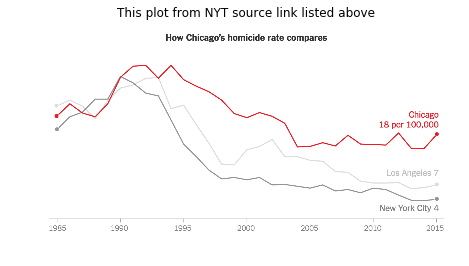

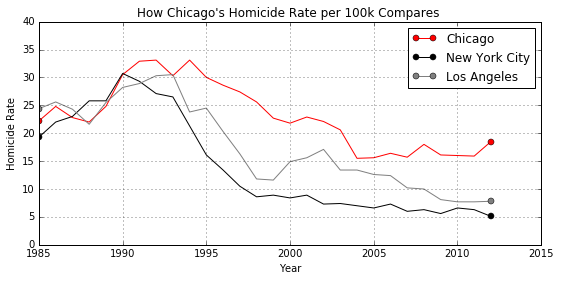

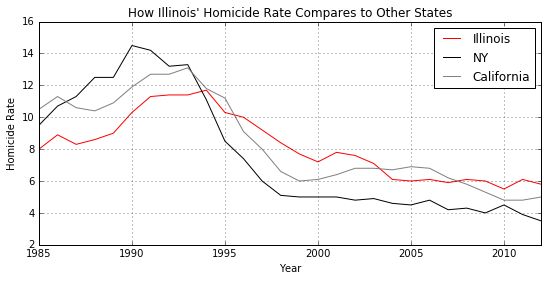

In [3]:
# Reproduce plot in NYT article Titled "How Chicago's homicide
# rate compares" to other big cities as sanity check 
markers_on=[0,df_Chi.shape[0]-1]

img = cv2.imread('NYT_CrimeRatesPlot.png')
plt.figure(figsize=(9,4))
plt.axis("off")
plt.title("This plot from NYT source link listed above")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.figure(figsize=(9,4))
plt.plot(df_Chi['Year'],df_Chi['Murder and nonnegligent manslaughter rate'],'-ro',\
         label='Chicago',markevery=markers_on)
plt.plot(df_NYPD['Year'],df_NYPD['Murder and nonnegligent manslaughter rate'],'-ko',\
         label='New York City', markevery=markers_on)
plt.plot(df_LAPD['Year'],df_LAPD['Murder and nonnegligent manslaughter rate'],'grey',\
         label='Los Angeles', marker='o', markevery=markers_on)
plt.ylim(0,40)
plt.xlabel("Year")
plt.ylabel("Homicide Rate")
plt.title("How Chicago's Homicide Rate per 100k Compares ")
plt.grid(True)
plt.legend()

plt.figure(figsize=(9,4))
plt.plot(df_IL['Year'],df_IL['Murder and nonnegligent manslaughter rate'],'r-',label='Illinois')
plt.plot(df_NY['Year'],df_NY['Murder and nonnegligent manslaughter rate'],'k-',label='NY')
plt.plot(df_CA['Year'],df_CA['Murder and nonnegligent manslaughter rate'],'grey',label='California')
plt.xlabel("Year")
plt.ylabel("Homicide Rate")
plt.title("How Illinois' Homicide Rate Compares to Other States")
plt.grid(True)
plt.legend()
plt.xlim(1985,2012)
plt.show()

I only found data through 2012, though NYT plot shows crime rates through 2015. 2015 was an interesting year for Baltimore crime rate per 100k, as there is a huge spike -- without the data, I won't explore that further here.

Crime rate per state is harder to disentangle because we're averaging over many cities to draw conclusions. Nevertheless, note that the state crime rates track closely with corresponding  major cities.An interesting read on the probable causes of the nearly unanimous decrease in crime rates during the 90s :
 http://pricetheory.uchicago.edu/levitt/Papers/LevittUnderstandingWhyCrime2004.pdf
 
In summary, Levitt argues the following causes for the decrease :
- Increase in number of police
- Increase in prison population
- Slowing of crack epidemic 
- Legalization of abortion

## 2.II Explore correlations between crime rate and variables such as population density, poverty index, etc

In [4]:
# Same plot as previous, but add some other cities 
# The contrast in rates between Baltimore and the other cities is striking
markers_on=[0,df_Chi.shape[0]-1]

# Compile list of most dangerous cities from here: 
# http://www.worldatlas.com/articles/most-dangerous-cities-in-the-united-states.html
# and get the corresponding areas from Google
cities = [ 'DetroitPD', 'MemphisPD', 'OaklandPD', 'StLouisPD', 'MilwaukeePD', 'BaltimorePD', 'Cleveland', 'Stockton',\
           'Indianapolis', 'KansasCity', 'BuffaloPD', 'AtlantaPD', 'DC', 'NashvillePD', 'Toledo', 'NewarkPD', 'MiamiPD',\
           'PhiladelphiaPD', 'MinneapolisPD', 'HoustonPD', 'NewOrleansPD', 'Cincinnati', 'OrlandoPD', 'ChicagoPD', \
           'AlbuquerquePD', 'StPetersburgPD', 'AnchoragePD', 'LasVegasPD', 'TulsaPD', 'Pittsburgh' ]

# Footage in square miles-- Note: LasVegas is 135.9 sq miles, but the data from UCR
# is for Las Vegas Metropolitan area, which is 600 sq miles 
sq_foot = [ 142.9, 324., 78., 65.98, 96.8, 92.28, 82.47, 62.1, 372., 319., 52.51, 132.4, 68.34, 526., 84.12, 26.11, 55.25,\
          141.7, 58.42, 627., 350., 79.54, 110.7, 234., 189.5, 137.6, 1969., 600., 196.8, 58.3]

# Get all csv files into a list for convenient access
crime_data = []
crime_rate = []

for i in xrange(len(cities)):
    data_i = pd.read_csv("Cities/%sCrimeStats.csv" % cities[i])
    df_i = pd.DataFrame(data_i,columns=cols)
    crime_data.append(df_i)
    
    last_el = crime_data[i]['Year'].shape[0] - 1    
    crime_rate.append(crime_data[i]['Murder and nonnegligent manslaughter rate'][last_el])
    
pop_dens = [ crime_data[i]['Population'][crime_data[i]['Population'].shape[0]-1]\
            /sq_foot[i]/1000 for i in xrange(len(sq_foot))]

#print "Population of las vegas in 2012: ", pop_dens[-3] * 135.9*1000

In [5]:
# Perform an ordinary least squares fit + evaluate influence of points to exclude outliers
# Then, exclude these points from fit to extract correlation between pop dens and crime rate
#http://statsmodels.sourceforge.net/
import statsmodels.api as sm

pop_dens_fit = sm.add_constant(pop_dens)
model = sm.OLS(crime_rate,pop_dens_fit).fit()

influ_v = model.get_influence()
influ_s = influ_v.summary_frame()['student_resid']
outliers = influ_s.ix[influ_s > 0.1] # 0.1 Chosen visually
nonoutliers = [ i for i in xrange(len(cities)) if i not in outliers ]

1.02624288388 7.93280983835


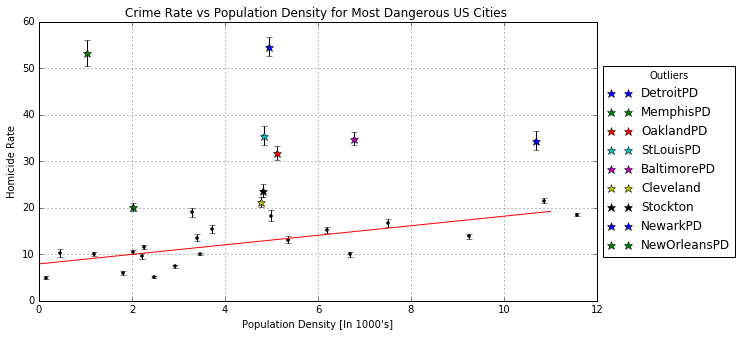

In [6]:
plt.figure(figsize=(10,5))

# Errors: Crime Rate = num crimes / population
# dCR = CR * srqt( (dPop /Pop,2) + (dCrimes / Crimes,2) )
# I don't have a good way to estimate error in crime (ie, how many
# were reported vs how many occurred), so I will only look at error in Pop
# which is sqrt(Pop)
yerr = [ crime_rate[i] * 1./math.sqrt(pop_dens[i] * sq_foot[i]) for i in xrange(len(cities))]
plt.errorbar(pop_dens, crime_rate, yerr=yerr, fmt='k.')

#Plot outliers + collect data for line fit
cr_plot = []
pd_plot = []
for i in xrange(len(cities)):
    last_el = crime_data[i]['Year'].shape[0] - 1    
    if i not in outliers:
        cr_plot.append(crime_data[i]['Murder and nonnegligent manslaughter rate'][last_el])
        pd_plot.append(pop_dens[i])
    else:
        plt.plot(float(pop_dens[i]),crime_rate[i],'*',label=cities[i],ms=9)        
    
# This fit neglects points the OLS has decided are outliers
fitx = np.arange(0,12,1)
m,b = np.polyfit(pd_plot, cr_plot,1)
print m, b

plt.plot(fitx,m*fitx+b,'r-')
plt.ylabel("Homicide Rate")
plt.xlabel("Population Density [In 1000's]")
plt.title("Crime Rate vs Population Density for Most Dangerous US Cities ")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),title='Outliers')
plt.grid(True)
plt.show()

This plot shows a correlation between the population density and crime rate; this makes intuitive sense.

What about the outlier points?

According to this website: http://www.worldatlas.com/articles/most-dangerous-cities-in-the-united-states.html, 7/9 of the outliers (pictured in the plot directly above) are in the top 10 most dangerous cities in the country. This suggests the presence of a more damning variable than population density. For example, is New Orleans' large deviation from the trend line related to Katrina? 

Note here I'm only using the crime rate of the last year of data. Let's check one last thing in this entry: are crime rates in these cities consistently higher, or are they only higher in this last year?

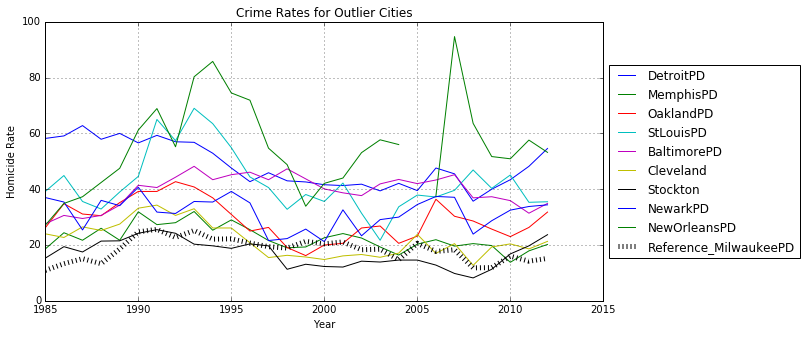

In [7]:
# Look at Crime rate comparison curves for outlier cities 
plt.figure(figsize=(10,5))
for i in xrange(len(cities)):
    if i in outliers:
        plt.plot(crime_data[i]['Year'],crime_data[i]['Murder and nonnegligent manslaughter rate'],label=cities[i])


#Plot one non-outlier for comparison
ref = nonoutliers[0]
plt.plot(crime_data[ref]['Year'],crime_data[ref]['Murder and nonnegligent manslaughter rate'],'k:',lw=5,label="Reference_%s"%cities[ref])

plt.xlabel("Year")
plt.ylabel("Homicide Rate")
plt.title("Crime Rates for Outlier Cities")
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Conclusion: It looks like on average, the crime in the most outlying cities is in fact higher on average. Cities like Cleveland + New Orleans which are nearly in agreement with the fit, are more consistent with the baseline reference.

In next entry, look into variables other than population density and their effects on crime rate.